<a href="https://colab.research.google.com/github/misaelLS21/datos_masivos/blob/master/proyecto_6/DM_proyecto6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicación de busqueda de Tweets usando LSH.
Autor: Misael López Sánchez.

En este notebook realizamos la implementación de el algoritmo Local Sensitive Hashing (LSH) para realizar la labor de la busqueda del vecino más cercano en una base de datos para los tweets públicados durantes los debates presidenciales en **Estados Unidos** el código de este trabajo se encuentra disponible en el repositorio de [GitHub](https://github.com/misaelLS21/datos_masivos) y la fuente de datos se pueden consultar del siguiente link de la página de [Kaggle](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment)

In [0]:
#Importamos las bibliotecas para el analisis de la información
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import floor 
import nltk
import random
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
'''
Descargamos las bibliotecas para poder hacer uso de lematizadores y 
tokenizar los textos de los tweets y crear bolsas de palabras que sirvan a 
manera de índices
'''

nltk.download(['punkt','averaged_perceptron_tagger','wordnet','stopwords'])
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ
from nltk.classify import SklearnClassifier

morphy_tag = {
    'JJ' : ADJ,
    'JJR' : ADJ,
    'JJS' : ADJ,
    'VB' : VERB,
    'VBD' : VERB,
    'VBG' : VERB,
    'VBN' : VERB,
    'VBP' : VERB,
    'VBZ' : VERB,
    'RB' : ADV,
    'RBR' : ADV,
    'RBS' : ADV
}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
''' 
Mandamos a llamar los datos directamente desde el repositorio de GitHub en donde
trabajaremos principalmente con los campos 'sentiment' & 'text' y mostramos
los datos en un DataFrame
'''


url = 'https://raw.githubusercontent.com/misaelLS21/datos_masivos/master/proyecto_6/Sentiment.csv'

#Cargamos los datos del archivo directamente desde nuestro repositorio de GitHub usando Pandas
dbTwitter = pd.read_csv(url,error_bad_lines=False)
pdTwitter = pd.DataFrame(dbTwitter)
pdTwitter[1:5]

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


# Introducción.
Lo que se muestra en el chunk anterior es una muestra de los valores que posee nuestra base de datos para los propositos de esta práctica los valoers sobre los cuales nos concentraremos serán los campos de **Sentiment** y **Text** como la base de datos es muy grande y hay muchos valoers disponible (Aparte de que colab se muere al usar toda la base de datos completa); sin embargo, dejamos la implementación de la base de datos completa por si se posee mayor capacidad de computo. Lo primero que hacemos es condentrarnos en analizar la información por sentimientos parecidos donde pre-clasificamos los datos de acuerdo con el sentimiento generlalizado en:

- Tweets Positivos
- Tweets Neutrales
- Tweets Negativos

La mayoría de los tweets son de tipo Negativos, así que serán estos sobre los cuales nos basaremos en la mayoria para realizar la clasificación y tokenización de la información.

In [4]:
'''
Leemos la longitud de la base de datos y vemos las caracteristicas de cada uno 
de los campos para ver el tipo de dato que representan
'''
print(dbTwitter.shape)
dbTwitter.info()

(13871, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-

In [0]:
#Extraemos de la base de datos los campos que nos interesan para trabajar
dataText = dbTwitter[['name','text','sentiment','candidate','tweet_location']]

Realizamos una representación pequeña del conjunto de datos que analizamos.

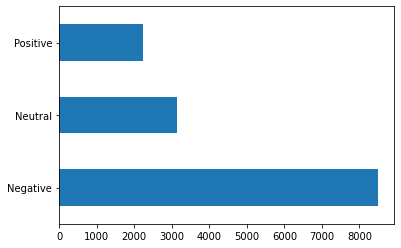

In [6]:
#Visualizamos como esta la distribucion de nuestro
dataText['sentiment'].value_counts().plot(kind="barh")

Nos desasemos de la información neutral y nos concentramos en uno de los polos el cual puede ya ser *Positivo* ó *Negativo*

In [7]:
#Excluimos los datos neutrales
dataText = dataText[dataText.sentiment != 'Neutral']
#Separamos los tweets por tweets positivos y negativos.
test_negative_tweets = dataText[dataText.sentiment == 'Negative'].shape[0]
test_positive_tweets = dataText[dataText.sentiment == 'Positive'].shape[0]

test_complete = dataText.shape[0]

print("Tweets negativos:", test_negative_tweets)
print("Tweets positivos :",test_positive_tweets)
print("Tweets completos: ",test_complete)

Tweets negativos: 8493
Tweets positivos : 2236
Tweets completos:  10729


Transformamos los datos a un formato DataFrame donde nos concentramos nadamás en el texto de los tweets una vez ya pre-clasificada la información.

In [8]:
# Separamos la información por positivos y negativos
dataText_positive = dataText[dataText.sentiment == 'Positive']
dataText_negative = dataText[dataText.sentiment == 'Negative']
dataText_complete = dataText

# Ahora sólo separamos los textos que es lo que realmente me importa
text_positive = pd.DataFrame(dataText_positive['text'])
text_negative = pd.DataFrame(dataText_negative['text'])
text_complete = pd.DataFrame(dataText['text'])

# Imprimimos las lontigudes
print("shape positivos", text_positive.shape)
print("shape negative", text_negative.shape)
print("shape complete", text_complete.shape)

# Ejemplos de los Tweets
text_negative[10:20]

shape positivos (2236, 1)
shape negative (8493, 1)
shape complete (10729, 1)


,text
21,RT @mchamric: RT “@TeaTraitors: #GOPDebate was...
22,RT @erinmallorylong: No *I* hate Planned Paren...
24,RT @MrPooni: Fox News trying to convince us yo...
25,#GOPDebate rankings: worst to be performance -...
26,RT @TheBaxterBean: Scott Walker's Abortion Ban...
27,"RT @feministabulous: It's not a competition, b..."
28,RT @mch7576: RT “@TeaTraitors: #GOPDebate was ...
29,RT @HillaryClinton: Watch the #GOPdebate? Bet ...
30,@fbhw they're going to need to borrow the trai...
31,RT @LisaVikingstad: Ted Cruz at the #GOPDebate...


In [0]:
#Preparamos el formato de las palabras para reconocer en inglés
stopwords_set = set(stopwords.words("english"))

Definimos una función auxiliar para limpiar los Tweets de las etiquetas, encabezados, hashtag, etc.

In [0]:
def prepare_data(data):
    """
    @Input: recibe un DataFrame con los tweets
    @Output: Regresa una lista con los tweets limpiados eliminando etiquetas de tweet
           y caracteres como '@','#', etc además de eliminar toda aquella palabra con longitud
           menor a 3 letras para eliminar conectoers, etc
    """
    tweets = []
    for index, series in data.iterrows():
        text = series.text.lower()
        #words = text
        words = text.split()
        words = [word for word in words if len(word) > 3 and not word in stopwords_set and  'http' not in word and not word.startswith('@') and not word.startswith(' " ') and not word.startswith('#') and not word.startswith('.') and 'RT' != word]
        tweets.append((words))

    #Reagrupamos todo para que podamos crear las bolsas de palabras
    lista = []
    for k in range(len(tweets)):
      sentence = tweets[k]
      texto = ' '.join(sentence)
      lista.append(texto)

    return lista

Transformamos limpiando los tweets de los carácteres no deseados como las etiquetas y encabezados de tweets.

In [11]:
# Limpieza de los tweets
data_positive = prepare_data(text_positive)
data_negative = prepare_data(text_negative)
data_complete = prepare_data(text_complete)

# Imprimimos las longitudes de los datos 
print("positivos",len(data_positive))
print("Negativos",len(data_negative))
print("Completa",len(data_complete))

#Ejemplo muestra
data_positive[10:20]

positivos 2236
Negativos 8493
Completa 10729


['focus groupers said favorable view trump. after, positively.',
 'made first donation impressed performance.',
 "donald trump's campaign reveals important thing: twitter trolls real people. vote. scare eve…",
 'bill martha team first debate. debate ambush.',
 'several candidates express faith son, jesus christ.',
 'great start friday.',
 "elected, first president, i'll rescind every illegal unconstitutional executive order enacted pres. oba…",
 "even though super conservative reporter, actually like megyn kelly's interview style &amp; great",
 'credit joke goes someone else funny!',
 "simply incredible. last night's doubled previous record most-watched primary debate"]

Tokenizamos la información para poder crear la bolsa de palabras.

In [0]:
def doc_a_tokens(doc):
  """
  @Input: Recibe una lista con Strings (Tweets) para leer elemento por elemento y lematizarlos y
          tokenizarlos
  @Output: Devuelve los elementos lematizados y tokenizados.

  """
  tagged = pos_tag(word_tokenize(doc.lower()))
  lemmatizer = WordNetLemmatizer()
  tokens = []
  for p,t in tagged:
    tokens.append(lemmatizer.lemmatize(p, pos=morphy_tag.get(t, NOUN)))
  return tokens

Volvemos a clasificar la información donde si queremos trabajar con los Tweets positivos lo especificamos en la variable **db_data** de lo contrario si queremos trabajar con los Tweets Positivos sólo descomentamos el la línea siguiente, lo mismo para trabajar con la base de datos completa.


In [0]:
#Para visualizar datos negativos
db_data = data_negative
textData = dataText_negative

#Para visualizar datos positivos
#db_data = data_positive
#textData = dataText_positive

#Para visualizar datos completos
#bd_data = data_complete
#textData = dataText_complete

Realizamos la partición de la información en una permutación aleatoria de consultas para después compar los documentos más parecidos con respecto a la base de Tweets usando consultas.

In [0]:
n = len(db_data) 
perm  = np.random.permutation(n).astype(int) # Generamos una permutación de tweets de la base
n_ej = int(floor(n*0.95))

#Creamos un conjunto y un subconjunto consulta de las bases
#base = [db_data[i] for i in perm[:n_ej]]
base = db_data
consultas = [db_data[i] for i in perm[n_ej:]]

In [15]:
f'la muestra de tweets tiene una dimensión de {len(base)} columnas'

'la muestra de tweets tiene una dimensión de 8493 columnas'

Calculamos las bolsas de palabras tanto para los Tweets de la base como de la consulta usando *CountVectorizer* con las que trabajaremos más adelante.

In [0]:
#Calculamos las bolsas de palabras del conjunto CountVectorizer
docs_base = []
for d in base:
  d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
  tokens = doc_a_tokens(d)
  docs_base.append(' '.join(tokens))

# Vectorizamos y tokenizamos la lista de twiits
v = CountVectorizer(stop_words='english', max_features=5000, max_df=0.8)
# Creamos la bolsa de palabras para la base
bolsas_base = v.fit_transform(docs_base)

Repetimos el mismo procedimiento tokenizando y creanod la bolsa de palabras para las consultas.

In [0]:
docs_consultas = []
for d in consultas:
  d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
  tokens = doc_a_tokens(d)
  docs_consultas.append(' '.join(tokens))

bolsas_consultas = v.transform(docs_consultas)

Mostramos la dimensión de ambas bolsas de palabras.

In [18]:
print("Dimension de la bolsa de palabras base",bolsas_base.shape)
print("Dimension de la bolsa de palabras base",bolsas_consultas.shape)

Dimension de la bolsa de palabras base (8493, 5000)
Dimension de la bolsa de palabras base (425, 5000)


# LSH
Función Local Sensitive Hash donde se instancia el código para realizar la inserción de las consultas similares dentro de tablas Hash.

In [0]:
class TablaLpLSH:
  def __init__(self, n_cubetas, t_tupla, dim, width, norma = 'l2'):
    self.n_cubetas = n_cubetas
    self.tabla = [[] for i in range(n_cubetas)]
    self.t_tupla = t_tupla
    self.dim = dim
    self.w = width

    #Definimos una de las normas con las cuales hemos de trabajar
    if norma == 'l2':
      self.Amat = np.random.standard_normal((t_tupla, dim))
    elif norma == 'l1':
      self.Amat = np.random.standard_cauchy((t_tupla, dim))

    #Parametro que restringe la funcion hash
    self.bvec = np.random.uniform(low=0, high=self.w, size=self.t_tupla)
    self.a = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
    self.b = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
    self.primo = 4294967291

  def __repr__(self):
    ''' @Summary: Creación de las celdas para cada tabla hash '''
    contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas)]
    return "<TablaHash :%s >" % ('\n'.join(contenido))

  def __str__(self):
    contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas) if self.tabla[i]]
    return '\n'.join(contenido)

  def sl(self, x, i):
    ''' @Summary: Instanciamos la caracteristica de localidad para las tablas hash '''
    return (self.h(x) + i) % self.n_cubetas

  def h(self, x):
    ''' @Summary: Función hash natural '''
    return x % self.primo

  def lphash(self, x):
    ''' @Summary: Función hash principal con la cual insertamos los registros en las tabals '''
    Amat = np.random.standard_cauchy((self.t_tupla,len(x)))
    bvec = np.random.uniform(low=0, high=self.w, size=self.t_tupla)
    prod = np.floor((Amat @ x.T + bvec) / self.w).astype(int)
    return np.sum(self.a * prod, dtype=np.ulonglong), np.sum(self.b * prod, dtype=np.ulonglong)
     
  def insertar(self, x, ident):
    ''' @Summary: Función para insertar registros dentro de de las tablas hash '''
    lph, v2 = self.lphash(x)

    llena = True
    for i in range(self.n_cubetas):
      cubeta = int(self.sl(v2, i))
      if not self.tabla[cubeta]:
        self.tabla[cubeta].append(lph)
        self.tabla[cubeta].append([ident])
        llena = False
        break
      elif self.tabla[cubeta][0] == lph:
        self.tabla[cubeta][1].append(ident)
        llena = False
        break

    if llena:
      print('¡Error, tabla llena!')

  def buscar(self, x):
    ''' @Summary: Función para buscar en las tablas los elemento similares '''
    mh, v2 = self.lphash(x)

    for i in range(self.n_cubetas):
      cubeta = int(self.sl(v2, i))
      if not self.tabla[cubeta]:
        return []
      elif self.tabla[cubeta][0] == mh:
        return self.tabla[cubeta][1]
    return []

Instanciamos un número t de tablah hash para insertar la información y creamos las tablas hash. 

Para este caso en especifico: 
* l tuplats de tablas: 60
* n_cubetas: $2^{13}$
* t_tuplas: 1
* w: 50

In [0]:
n_tablas = 60
dim = bolsas_base.shape[1]
tablas = [TablaLpLSH(2**13, 1, dim, 50.0) for _ in range(n_tablas)]

Creamos una función para poder extraer las palabras similares de cada documento y así buscarlas dentro de las tablas hash. 

In [0]:
def csr_to_ldb(csr):
  """
  @Input: Función que transforma la información para guardarlas en tablas tokenizadas para insertar los documentos en tablas hash
  @Output: Regresa los elementos de cada documento tokenizados en listas
  """
  ldb = [[] for _ in range(csr.shape[0])]
  coo = csr.tocoo()    
  for i,j,v in zip(coo.row, coo.col, coo.data):
    ldb[i].append(j)

  return ldb

In [0]:
ll_base = csr_to_ldb(bolsas_base)
ll_consultas = csr_to_ldb(bolsas_consultas)

Transformamos la lista de valores en arrays para insertar los elementos dentro de las tablas hash.

In [23]:
ll_base_arr = np.array([np.array(xi) for xi in ll_base])
ll_consultas_arr = np.array([np.array(xi) for xi in ll_consultas])

ll_base_arr.reshape(8493,1)

array([[array([2399, 2024, 2047, 2580,  245], dtype=int32)],
       [array([1172,  627,  544, 4122, 2785, 2427], dtype=int32)],
       [array([2650, 1148, 3025], dtype=int32)],
       ...,
       [array([3085,  610, 3834, 2807,  673], dtype=int32)],
       [array([1760,  518, 4178, 2453, 2911], dtype=int32)],
       [array([2846, 4895, 4316, 4437,  987, 3513, 1795, 1417, 2812, 3511],
      dtype=int32)]], dtype=object)

Realizamos la inserción de los elementos dentro de las tablas hash.

In [0]:
for i,x in enumerate(ll_base_arr):
  for t in range(n_tablas):
    tablas[t].insertar(x, i)

Buscamos todos los elementos comunes dentro de las tablas hash y los guardamos dentro de la lista *vecs* en forma de conjuntos.

In [0]:
vecs = []
for i,q in enumerate(ll_consultas_arr):
  dc = []
  for t in range(n_tablas):
      dc.extend(tablas[t].buscar(q))
  vecs.append(set(dc))

Mostramos como los elementos se estan registrando dentro de las tablas Hash

In [26]:
tablas[1]

<TablaHash :0::[0, [27, 279, 361, 409, 559, 573, 588, 675, 701, 712, 778, 783, 914, 1157, 1392, 2102, 2157, 2487, 2586, 2717, 2828, 2924, 3042, 3671, 3857, 4302, 4321, 4399, 4839, 5451, 5790, 6382, 6468, 6897, 7484, 7824, 7851, 7982]]
1::[18446744054509768078, [128, 169, 233, 447, 776, 1150, 2573, 4088, 4598, 4891, 5024, 6129, 6926, 7187, 8264]]
2::[18446744056643077360, [166, 226, 1380, 2183, 2249, 3837, 4418, 5353, 5857, 6396, 6847, 7498]]
3::[18446744053798664984, [327, 1386, 1538, 1770, 3575, 3681, 5260, 5400, 5906, 7314, 7945, 8152]]
4::[18446742347862342478, [356]]
5::[18446744057354180454, [57, 199, 511, 1051, 1911, 2689, 3437, 6602, 7096, 7948, 8015, 8297, 8394]]
6::[18446744058776386642, [138, 442, 2009, 3380, 4295, 4505, 4732, 4933, 6523, 6861, 7480, 7994, 8155]]
7::[18446744059487489736, [417, 1065, 1527, 1803, 1873, 2445, 3334, 3797, 4457, 6470, 7240, 7370, 7678, 7849, 7951]]
8::[18446744055931974266, [500, 2153, 2246, 3507, 4927, 5001, 5459, 5552, 7576]]
9::[18446744055220

Tranformamos las bolsas de balores a un n-array para poder comparar los registrso iguales.

In [0]:
#Transofrmamos la bolsas a narray
bolsas_consultas_arr = np.array(bolsas_consultas.toarray())
bolsas_base_arr = np.array(bolsas_base.toarray())

In [0]:
def distancia_euclidiana(x, y):
  """
  @Input: Recibe dos parametros numericos para calcular la distancia euclidiana que existe
  entre los registros documentos.
  @Output: Devuelve la distancia enclidiana calculada para dos registraos dados.
  """   
  return np.sqrt(np.sum((x - y)**2))

def distancia_coseno(x,y):
  """
  @Input: Recibe dos parametros numericos para calcular la distancia de similitud
  coseno que existe entre los registros documentos.
  @Output: Devuelve la distancia coseno calculada para dos registraos dados.
  """
  a = np.sum(x*y)
  b = np.sqrt(np.sum(x**2))
  c = np.sqrt(np.sum(y**2))
  return a/(b*c)
  

def fuerza_bruta(ds, qs, fd):
  """
  @Input: Recibe por parametros la bolsa de valores, los vectores consulta y la metrica 
  para realizar por medio de la fuerza bruta la comparación de los registros y así poder
  agruparlso por los vecinos más cercanos.

  @Output: Devuelve dos listas en la que la primeva se devuelven las distancias
  de acuerdo a la métrica introducida, y en la segunda se devuelven los indices 
  de los vecinos más cercanos con respecto al orden de similitud.
  """
  medidas = np.zeros(ds.shape[0])
  for i,x in enumerate(ds):
    medidas[i] = fd(qs, x)

  return np.sort(medidas)[::-1], np.argsort(medidas)[::-1]


Realizamos la comparación de los elementos comunes utilizando la distancia euclidiana.

In [0]:
sims_euclidiana = []
orden_euclidiana = []
for i,q in enumerate(bolsas_consultas_arr):
  ld = list(vecs[i])
  if ld:
    s,o = fuerza_bruta(bolsas_base_arr[ld], q, distancia_euclidiana)
    sims_euclidiana.append(s)
    orden_euclidiana.append([ld[e] for e in o])
  else:
    sims_euclidiana.append([])
    orden_euclidiana.append([])

Realizamos la comparación de los elementos comunes utilizando la distancia similitud coseno.

In [59]:
sims_coseno = []
orden_coseno = []
for i,q in enumerate(bolsas_consultas_arr):
  ld = list(vecs[i])
  if ld:
    s,o = fuerza_bruta(bolsas_base_arr[ld], q, distancia_coseno)
    sims_coseno.append(s)
    orden_coseno.append([ld[e] for e in o])
  else:
    sims_coseno.append([])
    orden_coseno.append([])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Ahora para un documento de muestra que sera el 5to, mostramos sus vecinos más cercanos usando tanto la métrica euclidiana como la métrica coseno.

In [0]:
documento = 2

In [64]:
# Documentos ordenados con respecto a su similitud euclidiana.
print(orden_euclidiana[documento])

[7879, 227, 676, 2887, 350, 5587, 773, 3937, 7040, 1440, 3868, 544, 2198, 1932, 4252, 6770, 1218, 2269, 420, 3455, 2514, 4680, 6661, 623, 8144, 5539, 6663, 694, 507, 8274, 421, 8408, 7889, 3208, 2711, 832, 2723, 4669, 4671, 2143, 331, 2644, 60, 837, 1384, 5878, 7583, 779, 3708, 661, 6127, 8184, 963, 2588, 4015, 1152, 24, 4736, 2267, 2722, 3553, 2062, 1645, 3532, 5576, 3562, 3551, 4570, 5511, 5731, 3466, 4498, 6664, 393, 8128, 1366, 6273, 121, 8305, 1035, 5132, 3130, 2237, 14, 4050, 4069, 7, 5244, 6134, 1285, 8186, 5854, 6502, 2399, 6485, 2865, 4903, 662, 896, 7603, 3159, 1358, 2810, 5481, 5181, 7545, 5330, 1036, 932, 5352, 1260, 1447, 1329, 3017, 5415, 5396, 1435, 5385, 881, 791, 2050, 7284, 8255, 5985, 6367, 3929, 6377, 6403, 2203, 262, 6435, 127, 2378, 385, 6043, 6343, 2117, 5776, 6202, 5687, 6150, 6166, 4693, 4585, 3601, 2543, 4103, 2637, 4081, 8196, 159, 2981, 7077, 7231, 140, 7186, 988, 6263, 1029, 6163, 3081, 6247, 71, 4281, 6802, 4305, 6994, 4760, 2690, 2599, 5223, 2564, 4802, 7

In [65]:
# Documentos ordenados con respecto a su similitud coseno
print(orden_coseno[documento])

[4092, 2772, 611, 623, 6768, 6770, 635, 4736, 2690, 6788, 6790, 2695, 649, 6802, 661, 662, 2711, 4760, 2722, 2723, 676, 4776, 2732, 694, 4802, 715, 4814, 4693, 2644, 6737, 6661, 2532, 4585, 2539, 2543, 2554, 507, 2564, 4612, 516, 6663, 6664, 2570, 2637, 4619, 529, 2588, 544, 6691, 2599, 4669, 4671, 581, 582, 4680, 6864, 4827, 4570, 731, 6994, 7005, 7016, 2923, 7020, 4971, 2926, 881, 4978, 2934, 4985, 7040, 896, 4998, 5000, 2953, 908, 932, 2981, 7077, 2990, 5040, 5041, 5050, 3005, 4945, 4943, 2887, 779, 2789, 6888, 745, 4843, 2810, 765, 769, 4867, 6915, 773, 6919, 4877, 837, 791, 798, 2847, 4903, 2865, 4914, 6963, 6966, 2877, 830, 832, 2529, 2516, 3011, 208, 2143, 6244, 103, 6247, 8305, 6263, 121, 6269, 127, 6273, 2177, 8327, 140, 144, 2198, 2203, 4252, 6301, 159, 4281, 4282, 189, 2237, 6343, 199, 6234, 8274, 6216, 4123, 8196, 6150, 7, 4103, 2062, 14, 4114, 6163, 6166, 24, 6170, 6173, 72, 4125, 8226, 38, 4142, 8239, 6202, 60, 8255, 2117, 71, 2120, 207, 4305, 2514, 6356, 4430, 6485, 344,

Definimos dos funciones para poder visualizar la información de los documentos similares.

In [0]:
#Imprimimos todos los documentos que son similares
def buscar_docs(documento,datos,base):
  """"
  @Input: Recibe el número del documento especifico que estamos buscando, 
  la información de la lista de vecinos comunes  y la base donde debe de buscarlos.
  @Output: Devuelve a forma de lista todos los documentos similares calculados
  usando las funciones SLH con la norma establecida
  """
  resultados = []
  for k in range(len(datos[documento])):
    resultados.append(base[list(datos[documento])[k]])
  return resultados

In [0]:
def busca_usuarios(documento,datos,base):
  """
  @Input: recibe el documento en especifico que estamos buscando,
  la información de la lista de vecinos comunes y la base donde debe de buscarlos.
  @Output: Devuelve a manera de DataFrame el nombre del individuo que realizo el 
  tweet, el tweet completo, el sentimiento de su tweet, el candidato al que hizó
  mención y la ubicación desde donde hizo el tweet
  """
  return base.iloc[datos[documento],:]

Para la metríca euclidiana mostramos los documentos similares para el documeto solicitado.

In [68]:
busca_usuarios(documento,orden_euclidiana,textData)

,name,text,sentiment,candidate,tweet_location
12954,Backstorymom1,RT @SupermanHotMale: Donald Trump: I have neve...,Negative,Donald Trump,NaN
390,Kelly62u,@ChrisChristie @RandPaul Americans fear NOT. P...,Negative,Chris Christie,"DFW, TX"
1161,BrittRic,RT @feministabulous: Scott Walker is so pro-li...,Negative,Scott Walker,North Coast // Wisconsin
4928,imuszero,Disappointed in @FoxNews coverage of #GOPDebat...,Negative,No candidate mentioned,"California, USA"
623,DykstraDame,The #GOPDebate was like a super crappy cage fi...,Negative,No candidate mentioned,NY
...,...,...,...,...,...
12900,kimwill66742942,RT @goldietaylor: Huckabee. #GOPDebates http:/...,Negative,NaN,CHESTERFIELD
7677,FromAToZany,@StephenAtHome Here's my take on the GOP debat...,Negative,No candidate mentioned,Greater Cincinnati
7629,erbarker,@megynkelly was the big loser in #GOPDebate #...,Negative,No candidate mentioned,Bethlehem Ga. USA
10877,monaeltahawy,Can someone send this to #GOPDebates #BlackLiv...,Negative,No candidate mentioned,Cairo/NYC


Devolvemos los mismos Tweets pero sólo el texto y en formato de lista.

In [70]:
resultado = buscar_docs(documento,orden_euclidiana,base)
resultado

['donald trump: never gone bankrupt... really donald? really donald? fucking liar...',
 'americans fear not. people live fear free liberty. fear unamerican',
 'scott walker pro-life make exception rape, incest life mother 20-week abo…',
 'disappointed coverage acted like giddy amateurs sporting event using liberal media questioning tactics👎🏼',
 'like super crappy cage fight blustering, bumbling, wrinkled-up tuckus clinchers without cage.',
 'trump buys politicians, used bankruptcy advantage, skirted laws money, admitted wanting single payer',
 'watching last night. ouf, tough hearing donald trump speak. gonna long road republican nomination.',
 "candidate consistently talks &amp;plans cutting forms immigration quickly gain electorate's support.#gopdebate",
 'hate call social security entitlement. government fund social security employer…',
 'faced “the hug” problem &amp; responded hugged 9/11 victims. left thinking, huh?',
 'topics left 50th anniversary voting rights act, voting rights

Mismas instrucciones anteriores pero ahora para la similitud Coseno.

In [71]:
busca_usuarios(documento,orden_coseno,textData)

,name,text,sentiment,candidate,tweet_location
7066,DawnyaJohnson,"RT @Tess_Harkin: No, #DonaldTrump, YOU'RE stup...",Negative,Donald Trump,"Baltimore, MD"
4722,ThirtyBirdy,"RT @TheFreshBrew: Well, that was embarrassing....",Negative,No candidate mentioned,NaN
1055,Mhmod_Alshmre,"At the second break, @Newsweek's #GOPDebate bi...",Negative,No candidate mentioned,المملكة العربية السعودية
1076,JosephinaRayer,"RT @JohnGGalt: Fox News keeps hammering, accor...",Negative,No candidate mentioned,NaN
11248,bugsboom,"Ted, look at history: that was a deal to bolst...",Negative,Ted Cruz,"Richmond area, VA"
...,...,...,...,...,...
5875,lexingtonnet,RT @Popehat: #GOPDebate Trump: the system is s...,Negative,Donald Trump,"Minneapolis, MN"
5880,ECHOPDA,"RT @davidbadash: Huckabee, wrong again...\n\nh...",Negative,Mike Huckabee,NaN
2311,DianeSnavely,"RT @fieldnegro: No Jeb, u can't blame this one...",Negative,Jeb Bush,"So.Nevada, USA"
2322,CassiProphetess,RT @AnneBayefsky: .@RealBenCarson: Skin &amp; ...,Negative,Ben Carson,NaN


In [72]:
buscar_docs(documento,orden_coseno,base)

['stupid.',
 'well, embarrassing.',
 'second break, bingo empty spaces left',
 'news keeps hammering, according plan, great carly fiorina last night—but remember word said.',
 'ted, look history: deal bolster reagan!',
 'boy: "social issues" code control women\'s bodies &amp; sexuality most. hold tight, twitterland',
 'watching check',
 'women start protesting misogyny "stay vagina unless want there!" placards.',
 'horrible. seriously. hate liberal alive today.',
 'everybody orange?',
 'would never know frontrunner watching debate.',
 'would talking "political correctness" referring instead women?',
 "here's frustrating watch woman",
 '"abandoning allies." that\'s cruz hyperbole. drink, folks.',
 'political debates teach marketers message audiences today. direct deflect!',
 "3:52am. fine, give turning dvr, watching trump's crack: think he's sti…",
 'course sponsored efficient method share right wing lunatic fringe statements extended family.',
 'misogyny surprise considering stage, pon

Ahora implementamos una función para ubicar a los elementos comunes usando ambas metricas.

In [0]:
#Usamos una lista por comprención para buscar los elementos comunes en ambas metrícas
def common_elements(list1, list2,elemento):
    return [element for element in list1[elemento] if element in list2[elemento]]

In [0]:
comunes = common_elements(orden_coseno,orden_euclidiana,documento)

Usando una comparación de los elementos comunes usando ambas metricas, estos son los vecinos más cercanos.

In [75]:
textData.iloc[comunes,:]

,name,text,sentiment,candidate,tweet_location
7066,DawnyaJohnson,"RT @Tess_Harkin: No, #DonaldTrump, YOU'RE stup...",Negative,Donald Trump,"Baltimore, MD"
4722,ThirtyBirdy,"RT @TheFreshBrew: Well, that was embarrassing....",Negative,No candidate mentioned,NaN
1055,Mhmod_Alshmre,"At the second break, @Newsweek's #GOPDebate bi...",Negative,No candidate mentioned,المملكة العربية السعودية
1076,JosephinaRayer,"RT @JohnGGalt: Fox News keeps hammering, accor...",Negative,No candidate mentioned,NaN
11248,bugsboom,"Ted, look at history: that was a deal to bolst...",Negative,Ted Cruz,"Richmond area, VA"
...,...,...,...,...,...
5875,lexingtonnet,RT @Popehat: #GOPDebate Trump: the system is s...,Negative,Donald Trump,"Minneapolis, MN"
5880,ECHOPDA,"RT @davidbadash: Huckabee, wrong again...\n\nh...",Negative,Mike Huckabee,NaN
2311,DianeSnavely,"RT @fieldnegro: No Jeb, u can't blame this one...",Negative,Jeb Bush,"So.Nevada, USA"
2322,CassiProphetess,RT @AnneBayefsky: .@RealBenCarson: Skin &amp; ...,Negative,Ben Carson,NaN
